In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import math
import shutil
from scipy.stats import norm

# Define the device etc
#torch.set_default_dtype(torch.float64)
N_BOUND = -30 if torch.get_default_dtype() == torch.float64 else -20
DTYPE = torch.get_default_dtype()

In [2]:
FONTSIZE = 18

# Try LaTeX settings, fall back gracefully
try:
    if shutil.which("latex") is not None:
        plt.rc("text", usetex=True)
        plt.rc(
            "text.latex",
            preamble=r"\usepackage{amsmath}\usepackage[bitstream-charter]{mathdesign}",
        )
        plt.rc("font", family="serif", size=FONTSIZE, serif="Charter")
    else:
        raise RuntimeError("LaTeX not found")
except Exception:
    # Fallback to default matplotlib serif font
    plt.rc("text", usetex=False)
    plt.rc("font", family="serif", size=FONTSIZE)

plt.rc("axes", titlesize="medium")

# Define color cycle
colors = [f"C{i}" for i in range(5)]

In [3]:
# Get some simple toy function
def generate_data(n_samples, unc=0.2, channels=1., seed=None):
    """
    Simple 1D regression problem based
    """
    if seed is not None:
        np.random.seed(seed)
    x = np.concatenate((np.random.uniform(-1, -0.22, n_samples // 2), np.random.uniform(0.22, 1, n_samples - n_samples // 2)))
    y = 0.5 * np.sin(23*x) + x/2
    y_noise = y + np.random.randn(n_samples) * unc #* (x+1) + np.random.randn(n_samples) * unc/2
    return x, y_noise

In [4]:
class StackedLinear(nn.Module):
    """
    Efficient implementation of linear layers for ensembles of networks
    """
    def __init__(self, in_features, out_features, channels):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.channels = channels
        self.weight = nn.Parameter(torch.empty((channels, out_features, in_features)))
        self.bias = nn.Parameter(torch.empty((channels, out_features)))
        self.reset_parameters()

    def reset_parameters(self):
        for i in range(self.channels):
            torch.nn.init.kaiming_uniform_(self.weight[i], a=math.sqrt(5))
            fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(self.weight[i])
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            torch.nn.init.uniform_(self.bias[i], -bound, bound)

    def forward(self, input):
        return torch.baddbmm(self.bias[:,None,:], input, self.weight.transpose(1,2))

def kernel(x, y):
    """
    RBF kernel with median estimator
    """
    channels = len(x)
    dnorm2 = (x.reshape(channels,1,-1) - y.reshape(1,channels,-1)).square().sum(dim=2)
    sigma = torch.quantile(dnorm2.detach(), 0.5) / (2 * math.log(channels + 1))
    return torch.exp(- dnorm2 / (2*sigma))

In [5]:
# Example for a larger dataset
epochs = 1000
batch_size = 200
n_samples = batch_size*10
prior_width = 1
unc = 0.1
seed = 42

# get reproducible datapoints
x_train, y_train = generate_data(n_samples, unc=unc, seed=seed)

# Fit scaler and save the mean and std to undo
# scaling later
Y_STD = y_train.std()
Y_MEAN = y_train.mean()
y_train_scaled = (y_train - Y_MEAN) / Y_STD

# get dataset load
dataset = torch.utils.data.TensorDataset(torch.tensor(x_train[:, None], dtype=DTYPE), torch.tensor(y_train_scaled, dtype=DTYPE))
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [6]:
# Example for a larger dataset
hdn_dim = 32
channels = 10
beta = 1

model = nn.Sequential(
    StackedLinear(1, hdn_dim, channels),
    nn.GELU(),
    StackedLinear(hdn_dim, hdn_dim, channels),
    nn.GELU(),
    StackedLinear(hdn_dim, hdn_dim, channels),
    nn.GELU(),
    StackedLinear(hdn_dim, hdn_dim, channels),
    nn.GELU(),
    StackedLinear(hdn_dim, hdn_dim, channels),
    nn.GELU(),
    StackedLinear(hdn_dim, hdn_dim, channels),
    nn.GELU(),
    StackedLinear(hdn_dim, hdn_dim, channels),
    nn.GELU(),
    StackedLinear(hdn_dim, 2, channels),
)

opt = torch.optim.AdamW(model.parameters(), lr=5e-3, weight_decay=1 / (2*len(x_train)*prior_width**2))
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, epochs*len(loader))

for i in range(epochs):
    train_losses = np.array([])
    reg_losses = np.array([])
    for xb, yb in loader:
        h = model(xb[None,:,:].expand(channels,-1,-1))
        mu, log_sigma2 = h[:,:,0], h[:,:,1]
        
        # Heteroscedastic regression loss
        log_sigma2 = log_sigma2.clamp(N_BOUND, 11)
        reg = 0.5 * ((yb[None,:] - mu)**2 / log_sigma2.exp() + log_sigma2)
        
        # ensemble loss
        reg_mean, reg_std = reg.mean(dim=1), reg.std(dim=1)
        loss = torch.sum(reg_mean, dim=0)
        # repulsive interaction term
        # k = kernel(reg, reg.detach())
        # loss += beta * torch.sum((k.sum(dim=1) / k.detach().sum(dim=1) - 1) / len(x_train), dim=0)
        
        train_losses = np.append(train_losses, loss.item())
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        sched.step()
    
    train_losses_epoch = train_losses.mean()
    
    if i % 100 == 0:
        print(f"epoch={i}, loss={train_losses_epoch.item():.4f} " +
              f"reg-mean={reg_mean.mean().item():.4f}, std={reg_mean.std().item():.4f}, " +
              f"min={reg_mean.min().item():.4f}, max={reg_mean.max().item():.4f}")

epoch=0, loss=4.9091 reg-mean=0.4122, std=0.0285, min=0.3585, max=0.4442
epoch=100, loss=-7.2958 reg-mean=-0.7651, std=0.2659, min=-1.0067, max=-0.2112
epoch=200, loss=-9.6082 reg-mean=-0.9321, std=0.1482, min=-1.0669, max=-0.6439
epoch=300, loss=-10.5817 reg-mean=-1.0345, std=0.0453, min=-1.0808, max=-0.9391
epoch=400, loss=-10.7497 reg-mean=-1.0798, std=0.0376, min=-1.1232, max=-1.0153
epoch=500, loss=-11.0045 reg-mean=-1.0963, std=0.0141, min=-1.1164, max=-1.0754
epoch=600, loss=-11.0687 reg-mean=-1.0824, std=0.0148, min=-1.1129, max=-1.0702
epoch=700, loss=-11.1741 reg-mean=-1.1120, std=0.0093, min=-1.1283, max=-1.0964
epoch=800, loss=-11.2887 reg-mean=-1.1531, std=0.0054, min=-1.1610, max=-1.1460
epoch=900, loss=-11.3409 reg-mean=-1.1510, std=0.0053, min=-1.1586, max=-1.1449


In [7]:
# plot prediction and error bands
# note: only the predictive error is shown
# (i.e. the error from limited training statistics, as extracted by the repulsive ensemble)
means = []
sigmas2 = []
xx = torch.linspace(-1.25, 1.25, 5000, dtype=DTYPE)

with torch.no_grad():
    x_test = xx[None,:,None].expand(channels, -1, -1)
    h_test = model(x_test)
    mus, logsigma2 = h_test[:,:,0], h_test[:,:,1]
    log_sigma2 = log_sigma2.clamp(N_BOUND, 11)
    sigma2 = logsigma2.exp()

means.append(mus.detach().cpu().numpy())
sigmas2.append(sigma2.detach().cpu().numpy())

mus = np.stack(means, axis=1) * Y_STD + Y_MEAN
sigmas2 = np.stack(sigmas2, axis=1)
sig = np.sqrt(sigmas2) * Y_STD

mean = np.squeeze(mus.mean(axis=0))
std = np.squeeze(mus.std(axis=0))
sigmean = np.squeeze(sig.mean(axis=0))

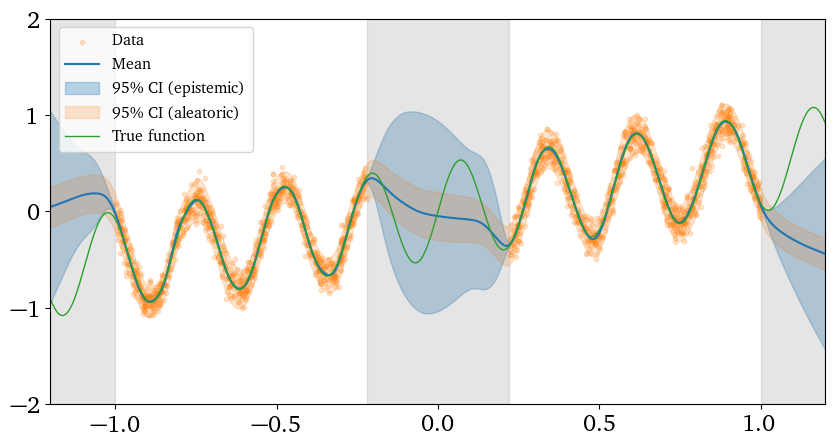

In [8]:
plt.figure(figsize=(10, 5))
plt.scatter(x_train,y_train, s=10, alpha=1/5, label='Data', color="C1")
plt.plot(xx, mean, color="C0", label='Mean')
z = norm.ppf(0.975)  # two-sided: (1 + 0.95)/2
lower = mean - z * std
upper = mean + z * std
lower_alea = mean - z * sigmean
upper_alea = mean + z * sigmean
plt.fill_between(xx, lower, upper, alpha=0.3, label=r'95\% CI (epistemic)', color="C0", zorder=-10)
plt.fill_between(xx, lower_alea, upper_alea, alpha=0.2, label=r'95\% CI (aleatoric)', color="C1")
plt.axvspan(-0.22, 0.22, color='gray', alpha=0.2)
plt.axvspan(1, 1.2, color='gray', alpha=0.2)
plt.axvspan(-1.2, -1.0, color='gray', alpha=0.2)
# plot the prediction with unc:
y = 0.5 * torch.sin(23*xx) + xx/2
plt.plot(xx, y, color="C2", label='True function', linewidth=1)
plt.legend(fontsize=FONTSIZE-6, loc='upper left')
plt.ylim(-2,2)
plt.xlim(-1.2,1.2)
plt.show()